In [1]:
from main import *
check_cuda()

PyTorch version: 1.13.1+cu116
CUDA available: True
CuDNN enabled: True


In [2]:
# use hdf5 to package MNIST data
import h5py
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import time
from IPython.display import clear_output

# load MNIST data
data_dir = os.path.join('./data')
mnist_dir = os.path.join(data_dir, 'MNIST/raw')
mnist_file = os.path.join(data_dir, 'MNIST/MNIST.hdf5')

In [3]:
if not os.path.exists(mnist_file):
    print('Create MNIST data ...')
    train_dataset = datasets.MNIST(data_dir, train=True, download=True,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                   ]))
    test_dataset = datasets.MNIST(data_dir, train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                  ]))

    print('Writing MNIST data to {}'.format(mnist_file))
    with h5py.File(mnist_file, 'w') as f:
        f.create_dataset('train_data', data=train_dataset.data.numpy())
        f.create_dataset('train_labels', data=train_dataset.targets.numpy())
        f.create_dataset('test_data', data=test_dataset.data.numpy())
        f.create_dataset('test_labels', data=test_dataset.targets.numpy())

print('Reading MNIST data from {}'.format(mnist_file))

!du -sh data/MNIST/raw
!du -sh data/MNIST/MNIST.hdf5

Reading MNIST data from ./data/MNIST/MNIST.hdf5
du: cannot access 'data/MNIST/raw': No such file or directory
53M	data/MNIST/MNIST.hdf5


In [4]:
with h5py.File(mnist_file, 'r') as f:
    # read MNIST data
    h5_train_data = f['train_data'][:]
    h5_train_labels = f['train_labels'][:]
    h5_test_data = f['test_data'][:]
    h5_test_labels = f['test_labels'][:]

    # convert to PyTorch tensors
    h5_train_data = torch.from_numpy(h5_train_data).float()
    h5_train_labels = torch.from_numpy(h5_train_labels).long()
    h5_test_data = torch.from_numpy(h5_test_data).float()
    h5_test_labels = torch.from_numpy(h5_test_labels).long()
    
    print('dataset statistics from MNIST.hdf5:')
    print('train_data:', h5_train_data.shape, h5_train_data.dtype)
    print('train_labels:', h5_train_labels.shape, h5_train_labels.dtype)
    print('test_data:', h5_test_data.shape, h5_test_data.dtype)
    print('test_labels:', h5_test_labels.shape, h5_test_labels.dtype)


# check the size of original dataset
def verification():
    train_dataset = datasets.MNIST(data_dir, train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))

    test_dataset = datasets.MNIST(data_dir, train=False, download=True,
                                    transform=transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,))
                                    ]))

    print('\ndataset statistics from torchvision:')
    print('train_data:', train_dataset.data.shape, train_dataset.data.dtype)
    print('train_labels:', train_dataset.targets.shape, train_dataset.targets.dtype)
    print('test_data:', test_dataset.data.shape, test_dataset.data.dtype)
    print('test_labels:', test_dataset.targets.shape, test_dataset.targets.dtype)

# verification()

dataset statistics from MNIST.hdf5:
train_data: torch.Size([60000, 28, 28]) torch.float32
train_labels: torch.Size([60000]) torch.int64
test_data: torch.Size([10000, 28, 28]) torch.float32
test_labels: torch.Size([10000]) torch.int64


In [5]:
# intialize the data loaders
train_dataset = torch.utils.data.TensorDataset(h5_train_data, h5_train_labels)
test_dataset = torch.utils.data.TensorDataset(h5_test_data, h5_test_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# train
for epoch in range(2):  
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch: {:d} loss: {:.3f}'.format(epoch + 1, running_loss / len(train_loader)))

Epoch: 1 loss: 0.836
Epoch: 2 loss: 0.386


In [6]:
# test the network
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: {:.2f}%'.format(100 * correct / total))

Accuracy: 91.01%


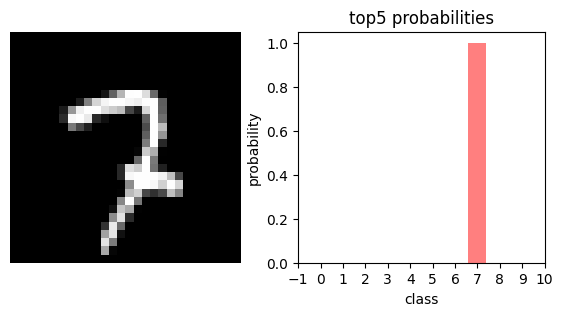

KeyboardInterrupt: 

In [7]:
# inference
def inference(index):
    inputs, _ = next(iter(test_loader))
    img = inputs[index].squeeze()

    plt.figure(figsize=(7, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    # top5 probabilities
    outputs = net(inputs)
    probs = F.softmax(outputs, dim=1)
    top5_probs, top5_classes = torch.topk(probs, 5)

    plt.subplot(1, 2, 2)
    plt.bar(top5_classes.detach().numpy()[index], top5_probs.detach().numpy()[index], color='red', alpha=0.5)
    plt.xticks([i-1 for i in range(12)])
    plt.xlabel('class')
    plt.ylabel('probability')
    plt.title('top5 probabilities')
    plt.show()

while 1:
    index = random.randint(0, 63)
    inference(index)
    time.sleep(3)
    clear_output(wait=True)